## Jointcal Astrometry ValidateDRP Summary Metrics on Run2.1i

### Intro to metrics computed

Validate_drp computes astrometric and photometric repeatabliity metrics per the SRD. See ls.st/LPM-17 for more info.
The astrometric repeatability metrics `AM1`, `AM2`, and `AM3` is the median RMS of distances between star pairs. 

The ELI5 version courtesy of John Parejko is: "Take a pair of stars ~5' apart on the sky. Any time that pair is seen in a single visit, record their separation. Compute the RMS of all those separations...that RMS is one datapoint. Do that for all such pairs separated by ~5': that is the histogram shown" below. The median of all those RMS's is the AM1. 

The 1, 2, 3 correspond to pairs 5', 20' and 200' apart to represent scales of an individual sensor, a raft, and
the camera. 

https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_3/validateDrp/validate-jointcal_i_validate_drp.AM1_D_5_arcmin_17.0_21.5_mag.png

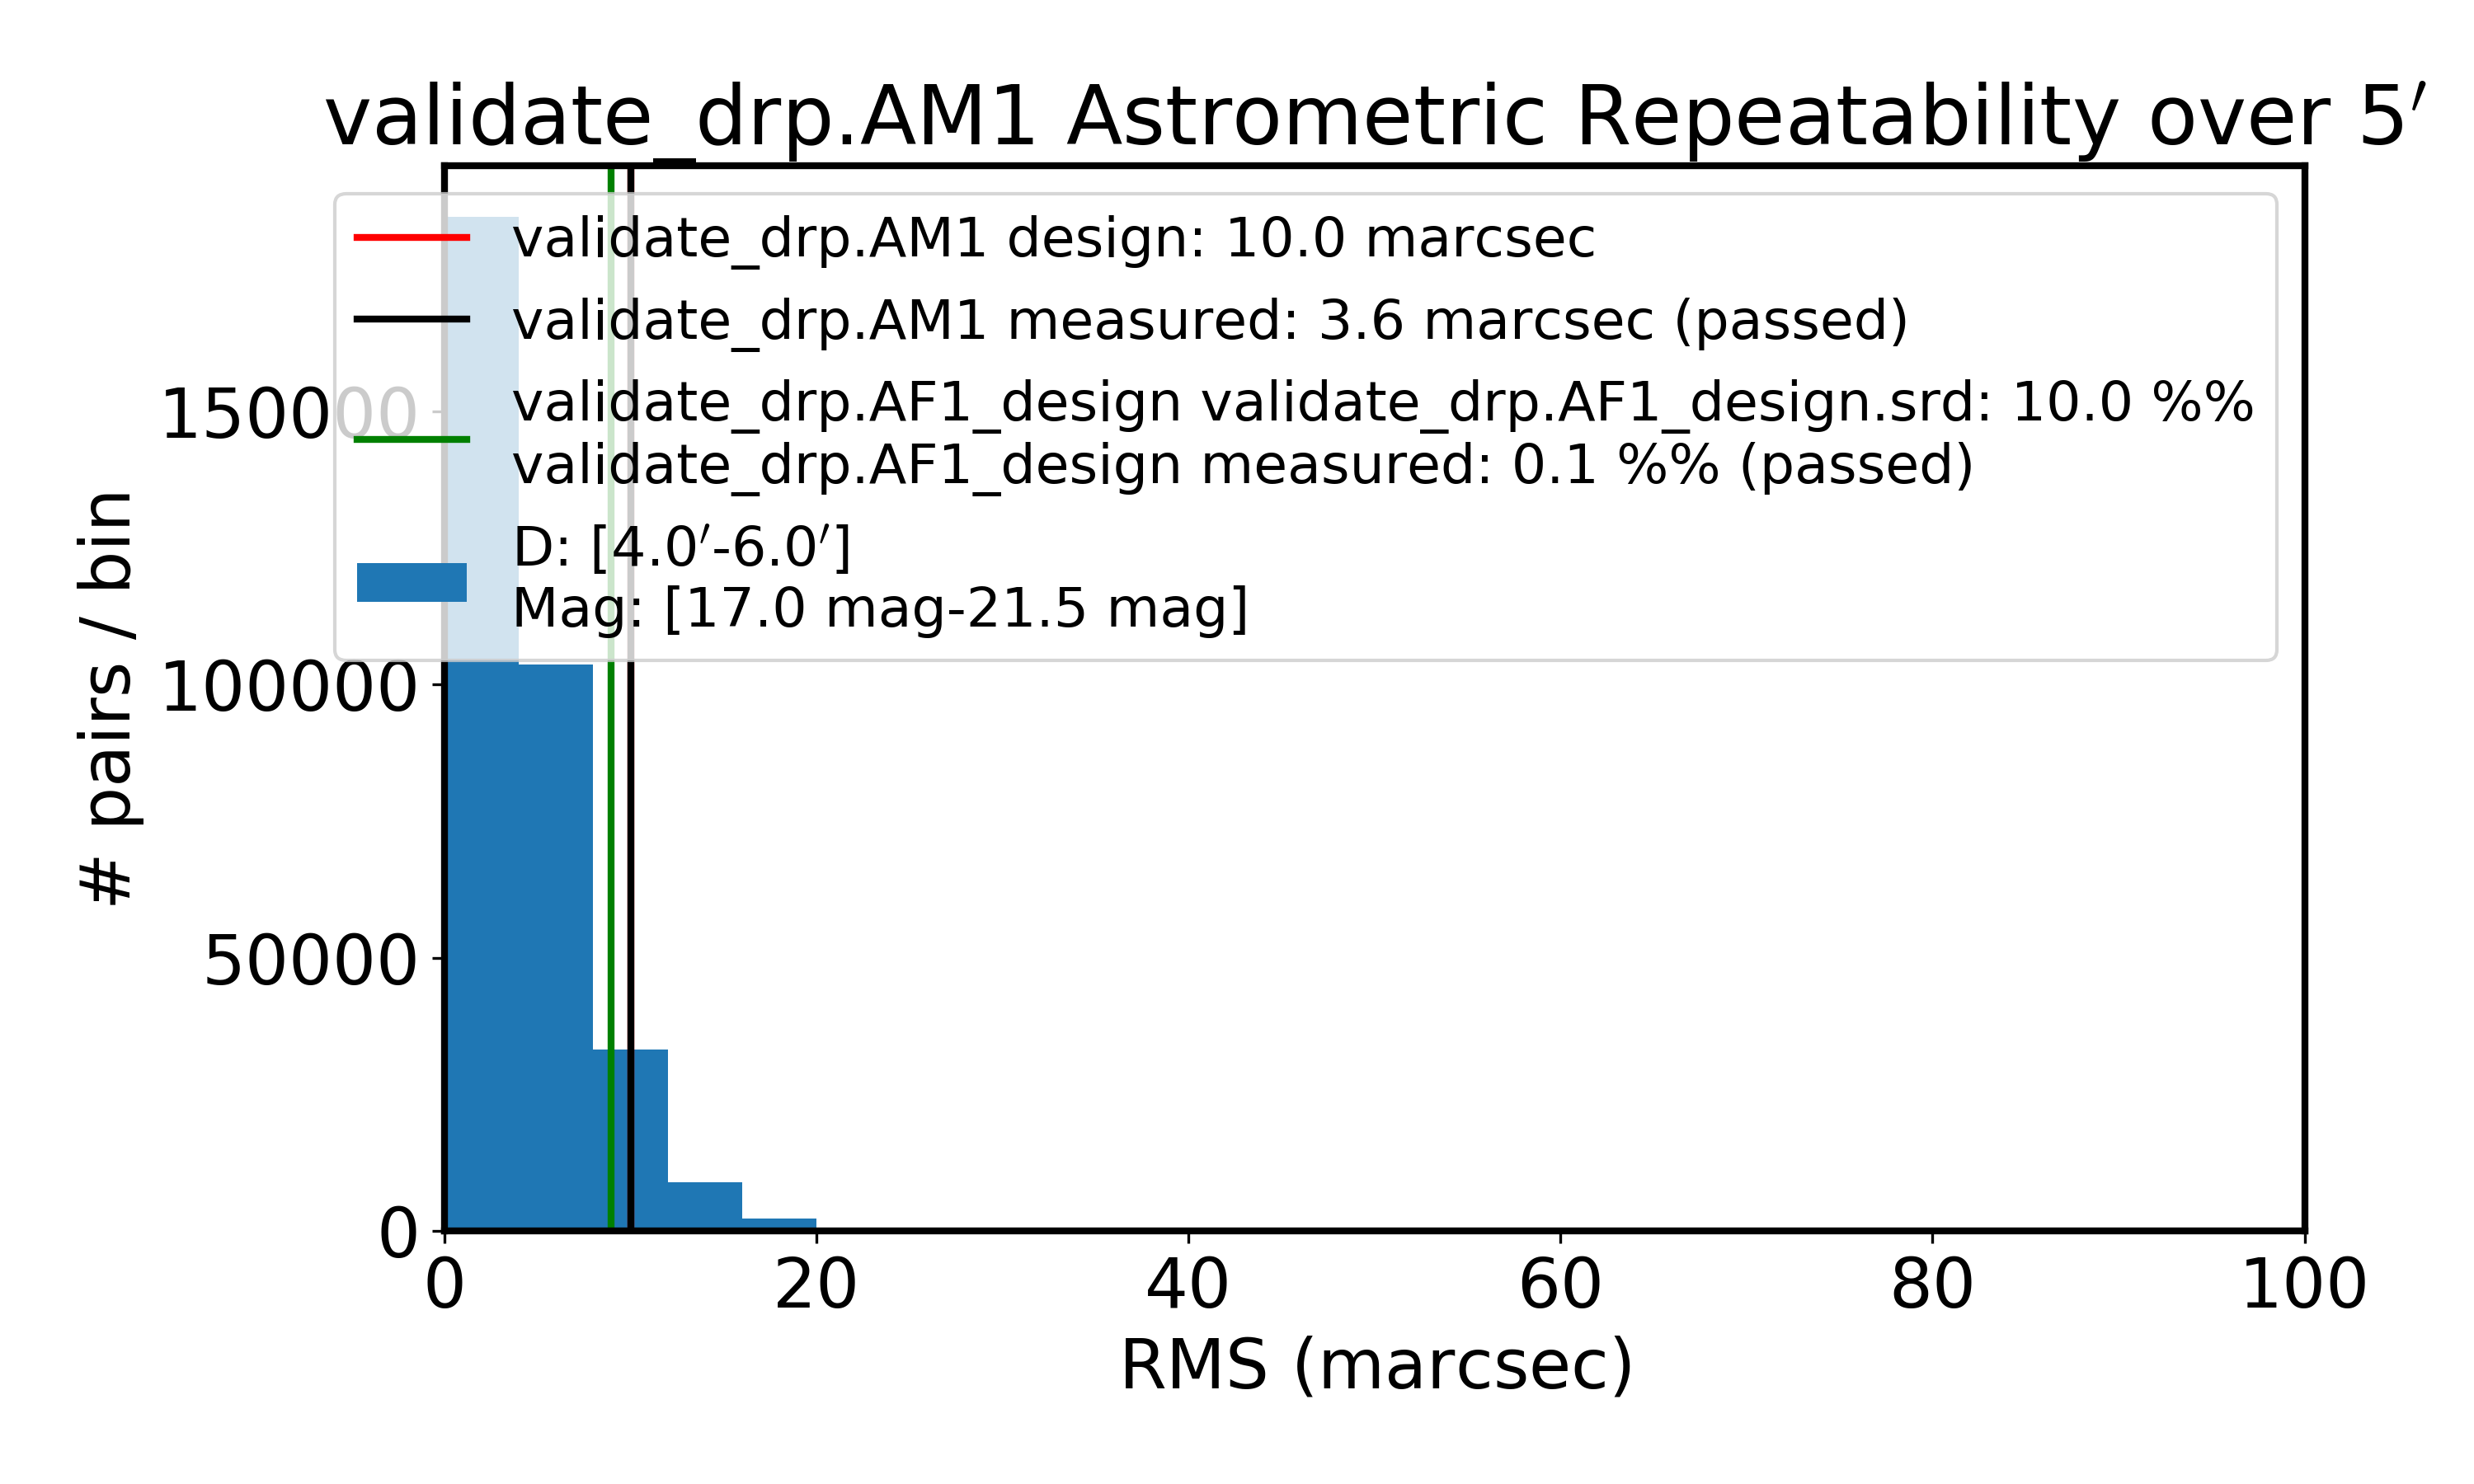

In [5]:
from IPython.display import Image
Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_3/validateDrp/validate-jointcal_i_validate_drp.AM1_D_5_arcmin_17.0_21.5_mag.png",
      width=600,)

The other validate_drp astrometry plot prints the naive distribution of the RMS variation in the position of stars. This is the metric that one thinks of first when they hear "repeatabiliy" and is the analog of PA1. 

Code that computes AMx can be found in:
* `https://github.com/lsst/validate_drp/blob/tickets/DM-18638/python/lsst/validate/drp/calcsrd/amx.py`

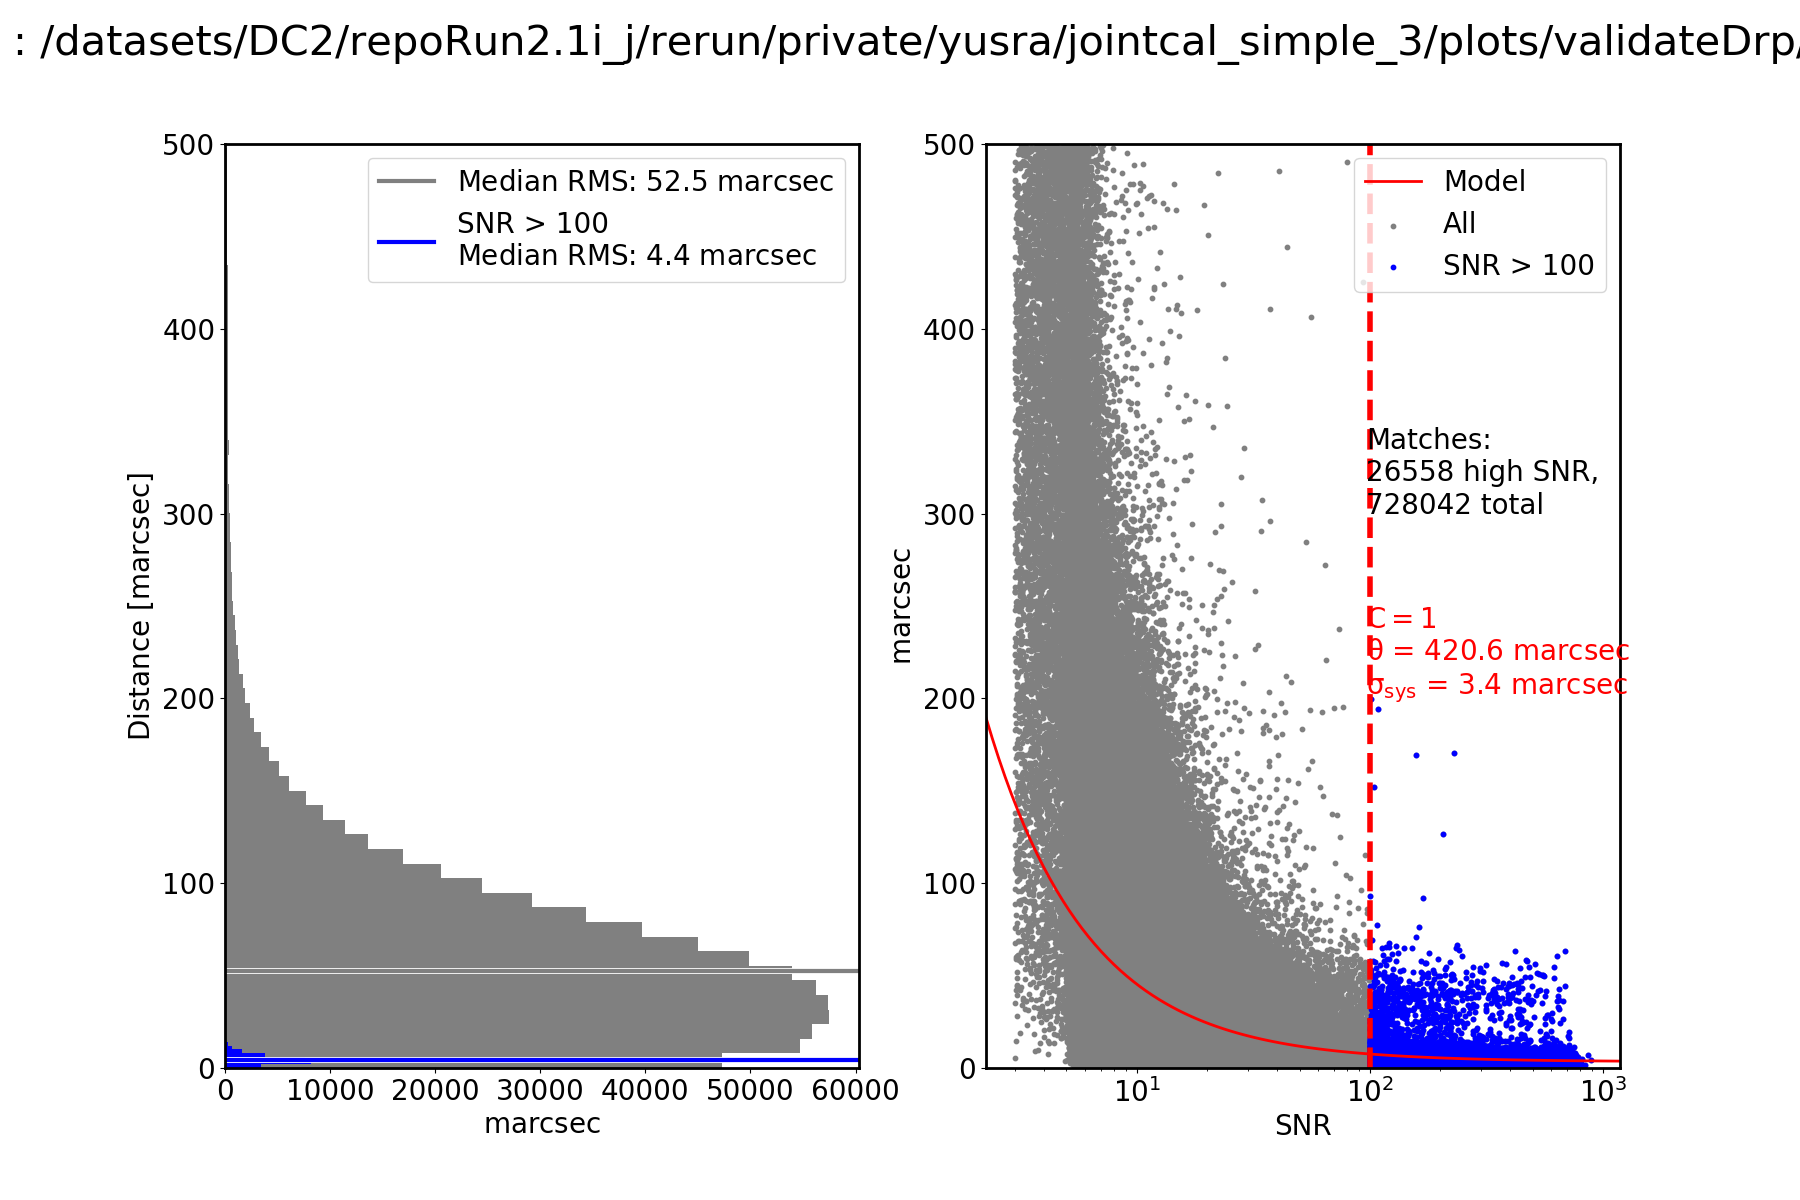

In [7]:
from IPython.display import Image
Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_3/validateDrp/validate-jointcal_i_check_astrometry.png",
      width=600,)

For this particular tract and filter, AM1 is 3.6 and the SNR median position RMS is 4.4mas. Close but not the same.

### Data (rerun configs)

Ran `visitAnalysis` and `validateDRP` on the following 5 configurations. 
QA plots can be found here:

* https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/processCcd (no jointcal cals applied)
* https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_default (jointcal with default constrained model)
* https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_stars_only (jointcal with default constrained model fitting only stars)
* https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_2 (jointcal with simple per ccd model order=2 fitting only stars)
* https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_3 (jointcal with simple per ccd model order=3 fitting only stars)

Expectation: Because the processCcd model (2nd order per CCD) has more degrees of freedom than the default constrained model (1st order per ccd and 7th order per focal place) we expect it to be bettwe than `jointcal_default`. We expect `jointcal_simple_2` to perfom the same as `processCcd` and `jointcal_simple_3` to perform better. 

In [8]:
import sys
import os
import numpy as np
import copy
import pickle
import json
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import seaborn as sns
import pandas as pd
%matplotlib inline  
sns.set_palette('Dark2')
sns.set(context='talk',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc={'text.usetex': False})

In [11]:
DIR_DICT_DC2 = {
    "processCcd": "/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/processCcd",
    "jointcal_default": "/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_default",
    "jointcal_stars_only": "/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_stars_only",
    "jointcal_simple_2": "/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_simple_2",
    "jointcal_simple_3": "/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_simple_3",
}

dc2 = pd.DataFrame()
rowList = []

FILTER = 'i'
TRACT = 3633
for dirName, DIR in DIR_DICT_DC2.items():
    dictDF = {}
    fname = "validate-processCcd_%s"%(FILTER) if dirName == "processCcd" else "validate-jointcal_%s"%(FILTER)
    path = os.path.join(DIR, 'plots/validateDrp', fname + '.json')
    print(path)
    with open(path) as json_file:
        data = json.load(json_file)
    print("loaded")
    values = [d['value'] for d in data['measurements']]
    metrics = [d['metric'].replace('validate_drp.', '') for d in data['measurements']]
    for metric, value in zip(metrics, values):
        dictDF[metric] = value
        dictDF['tract'] = TRACT
        dictDF['filter'] = FILTER
        dictDF['config'] = dirName
    rowList.append(dictDF)

dc2 = pd.DataFrame(rowList)

/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/processCcd/plots/validateDrp/validate-processCcd_i.json
loaded
/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_default/plots/validateDrp/validate-jointcal_i.json
loaded
/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_stars_only/plots/validateDrp/validate-jointcal_i.json
loaded
/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_simple_2/plots/validateDrp/validate-jointcal_i.json
loaded
/datasets/DC2/repoRun2.1i_j/rerun/private/yusra/jointcal_simple_3/plots/validateDrp/validate-jointcal_i.json
loaded


In [12]:
unitsDict = {}
for name, unit, disc in [(d['name'], d['unit'], d['description']) for d in data['metrics']]:
    unitsDict[name.replace('validate_drp.', '')] = (unit, disc)

### Comparison of the AMx Metrics:

We see roughly what we expect:  The `jointcal_simple_2` which uses jointcal with the same model as processCcd does performs a little better, and `jointcal_simple_2` performs better than that. Note that `jointcal_simple_2` and `jointcal_simple_3` also limit the internal fitting catalog to just stars, but I don't think it is the reason `jointcal_simple_2` performs better than `processCcd`, because it doesn't have an effect on the `jointcal_default` constrained model. 

In [17]:
dc2[['AM1', 'AM2','AM3','config']]

,AM1,AM2,AM3,config
0,4.277231,5.011310,4.901856,processCcd
1,5.530401,6.657783,6.681305,jointcal_default
2,5.542601,6.658859,6.717073,jointcal_stars_only
3,3.905723,4.591625,4.463139,jointcal_simple_2
4,3.550465,4.119915,3.979646,jointcal_simple_3


<Figure size 144x432 with 0 Axes>

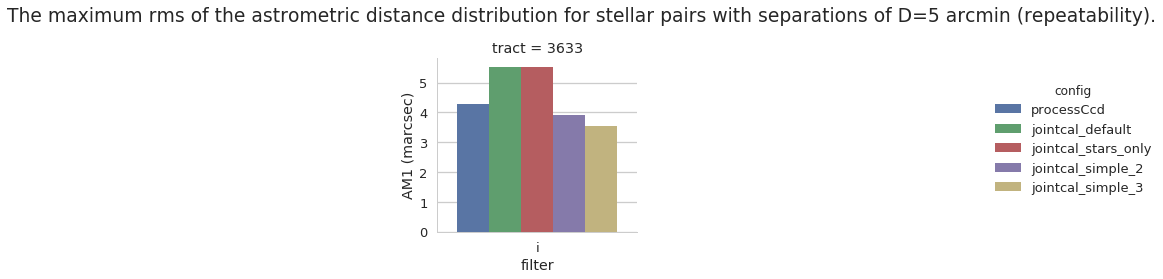

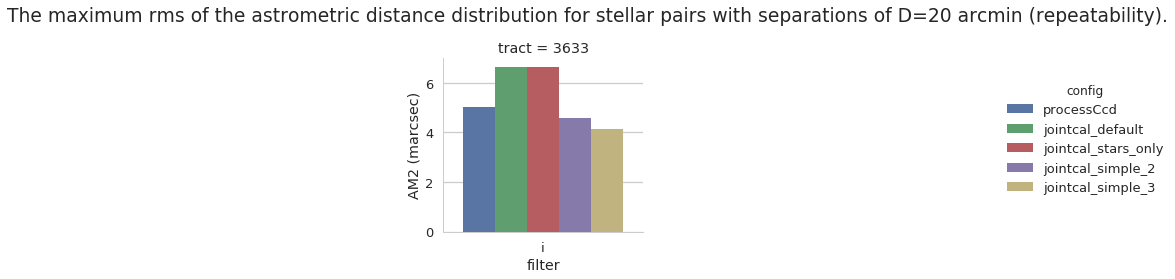

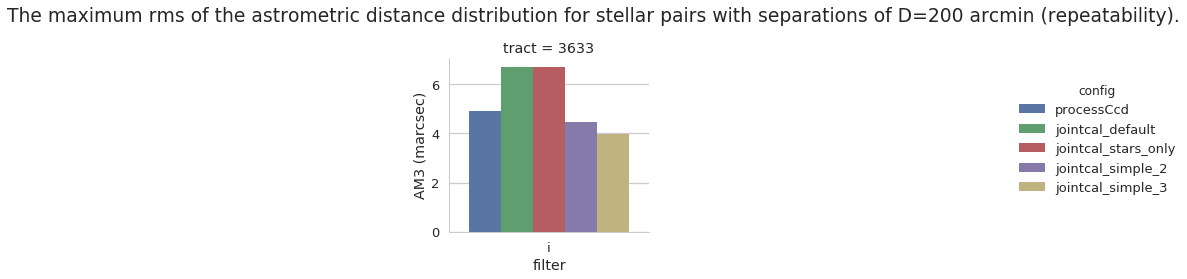

In [21]:
fig = plt.figure(figsize=(2, 6))
cols = ["AM1", "AM2", "AM3"] 
for col in cols:
    ax = sns.factorplot(x="filter", y=col, data=dc2,
                        hue="config", col="tract", kind="bar")
    ax.fig.suptitle(unitsDict[col][1])
    ax.fig.subplots_adjust(top=0.8)
    ax.set_ylabels("%s (%s)"%(col, unitsDict[col][0]))
    plt.show()

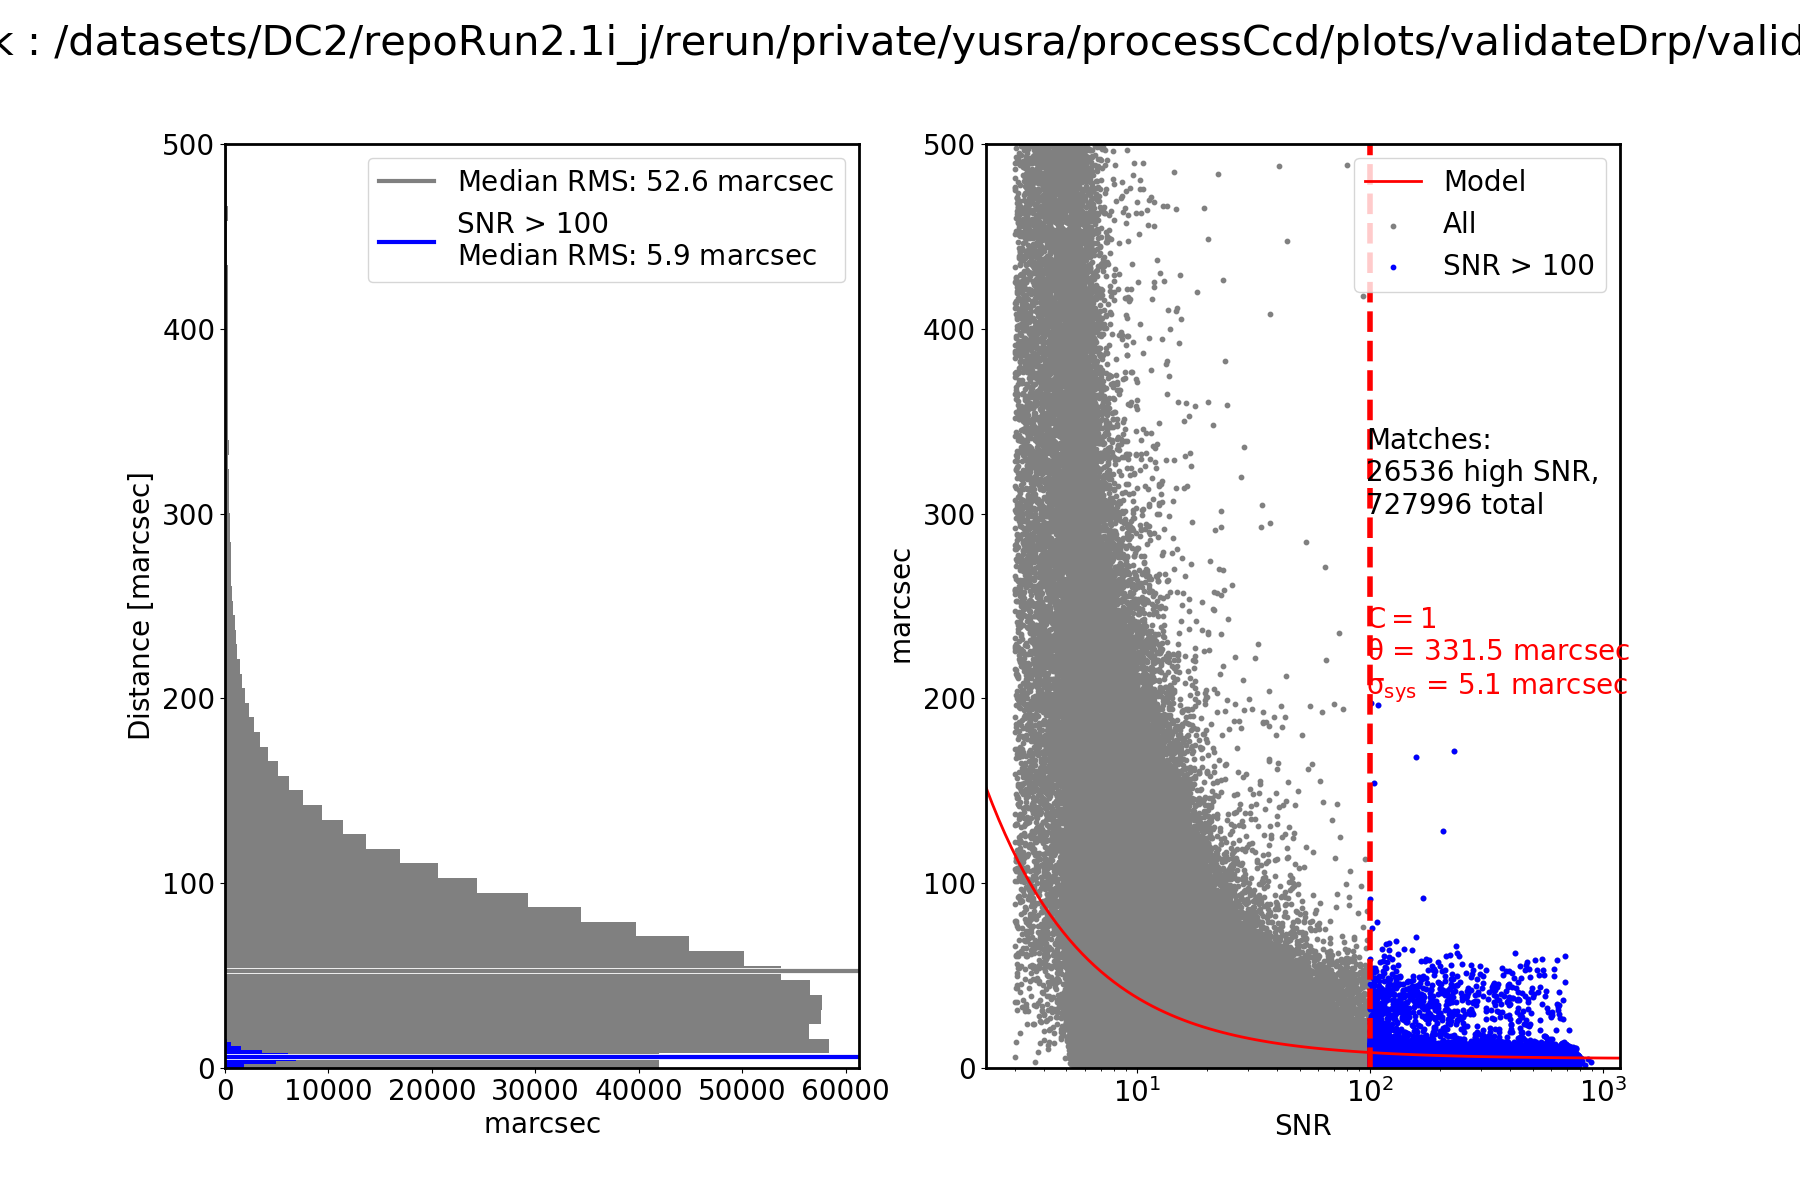

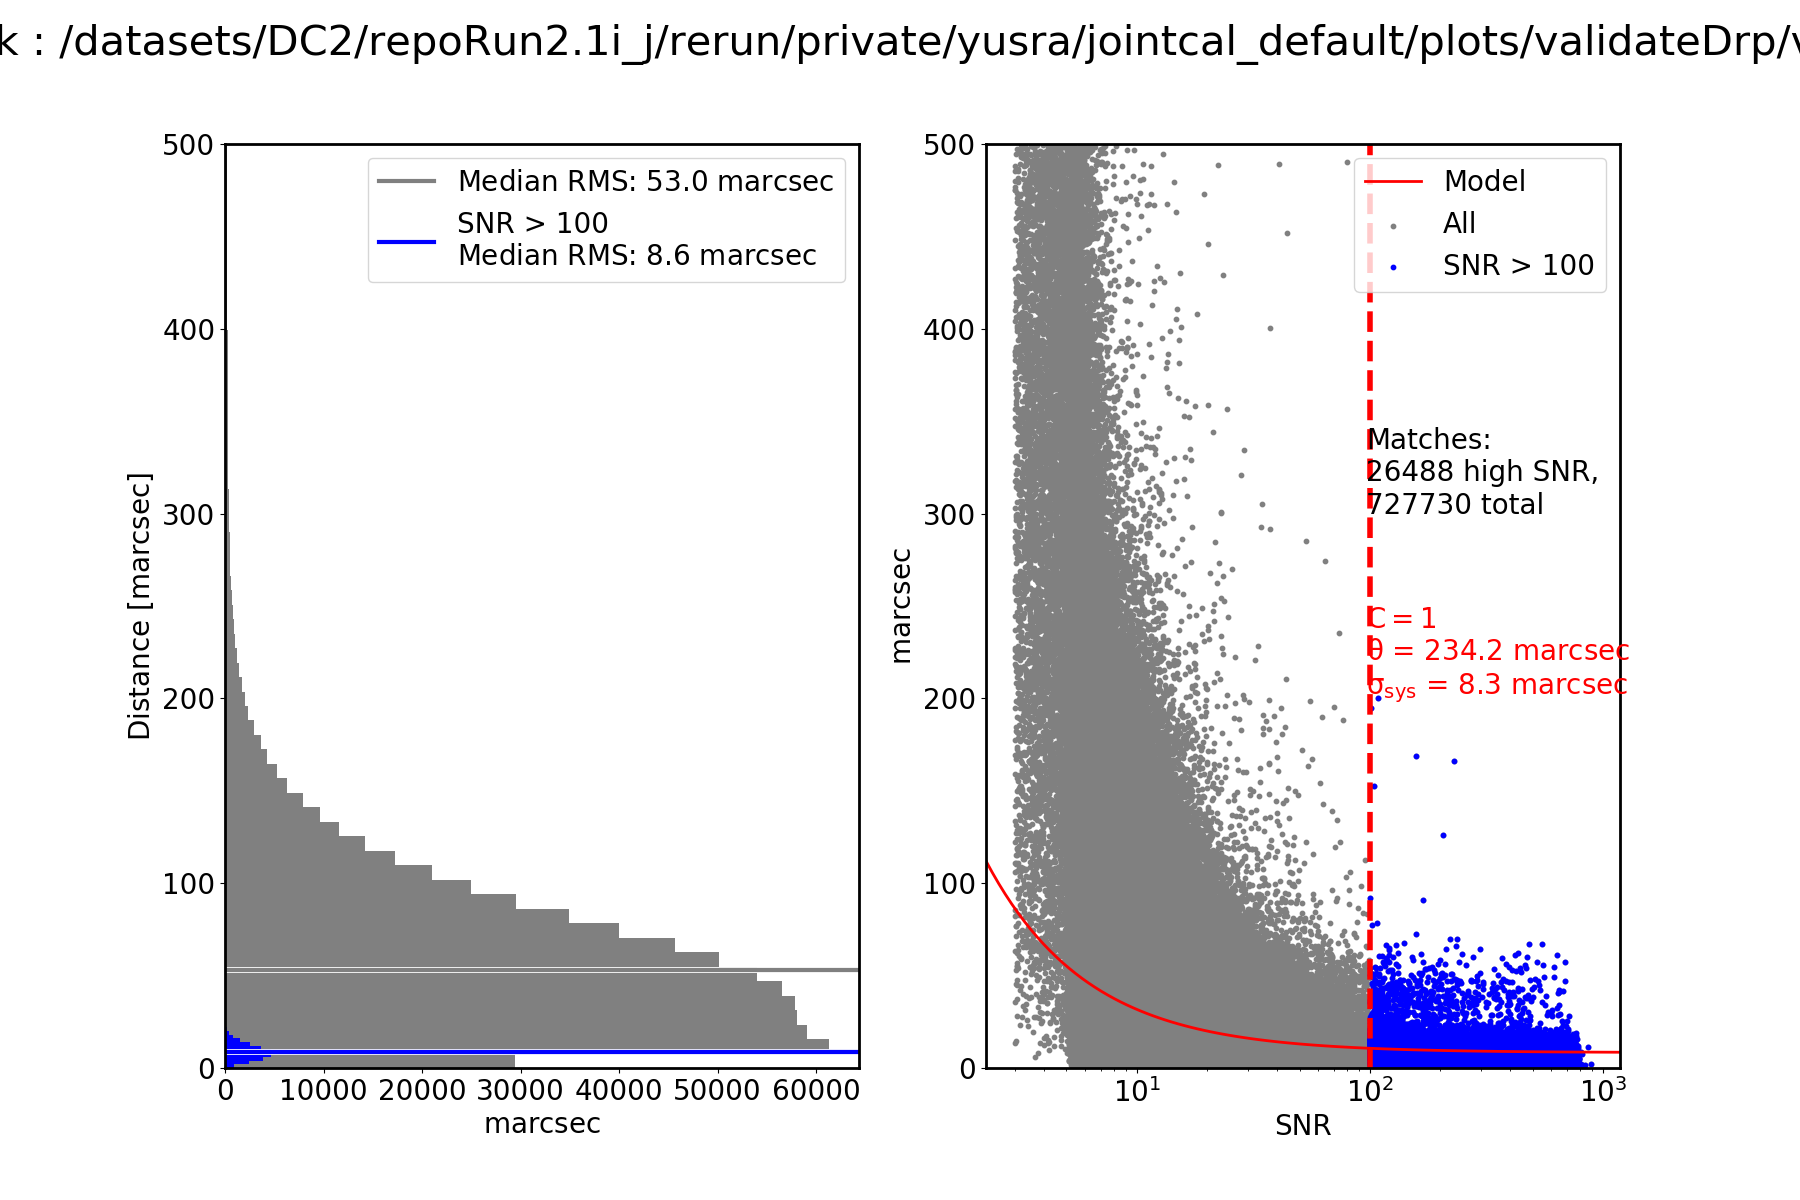

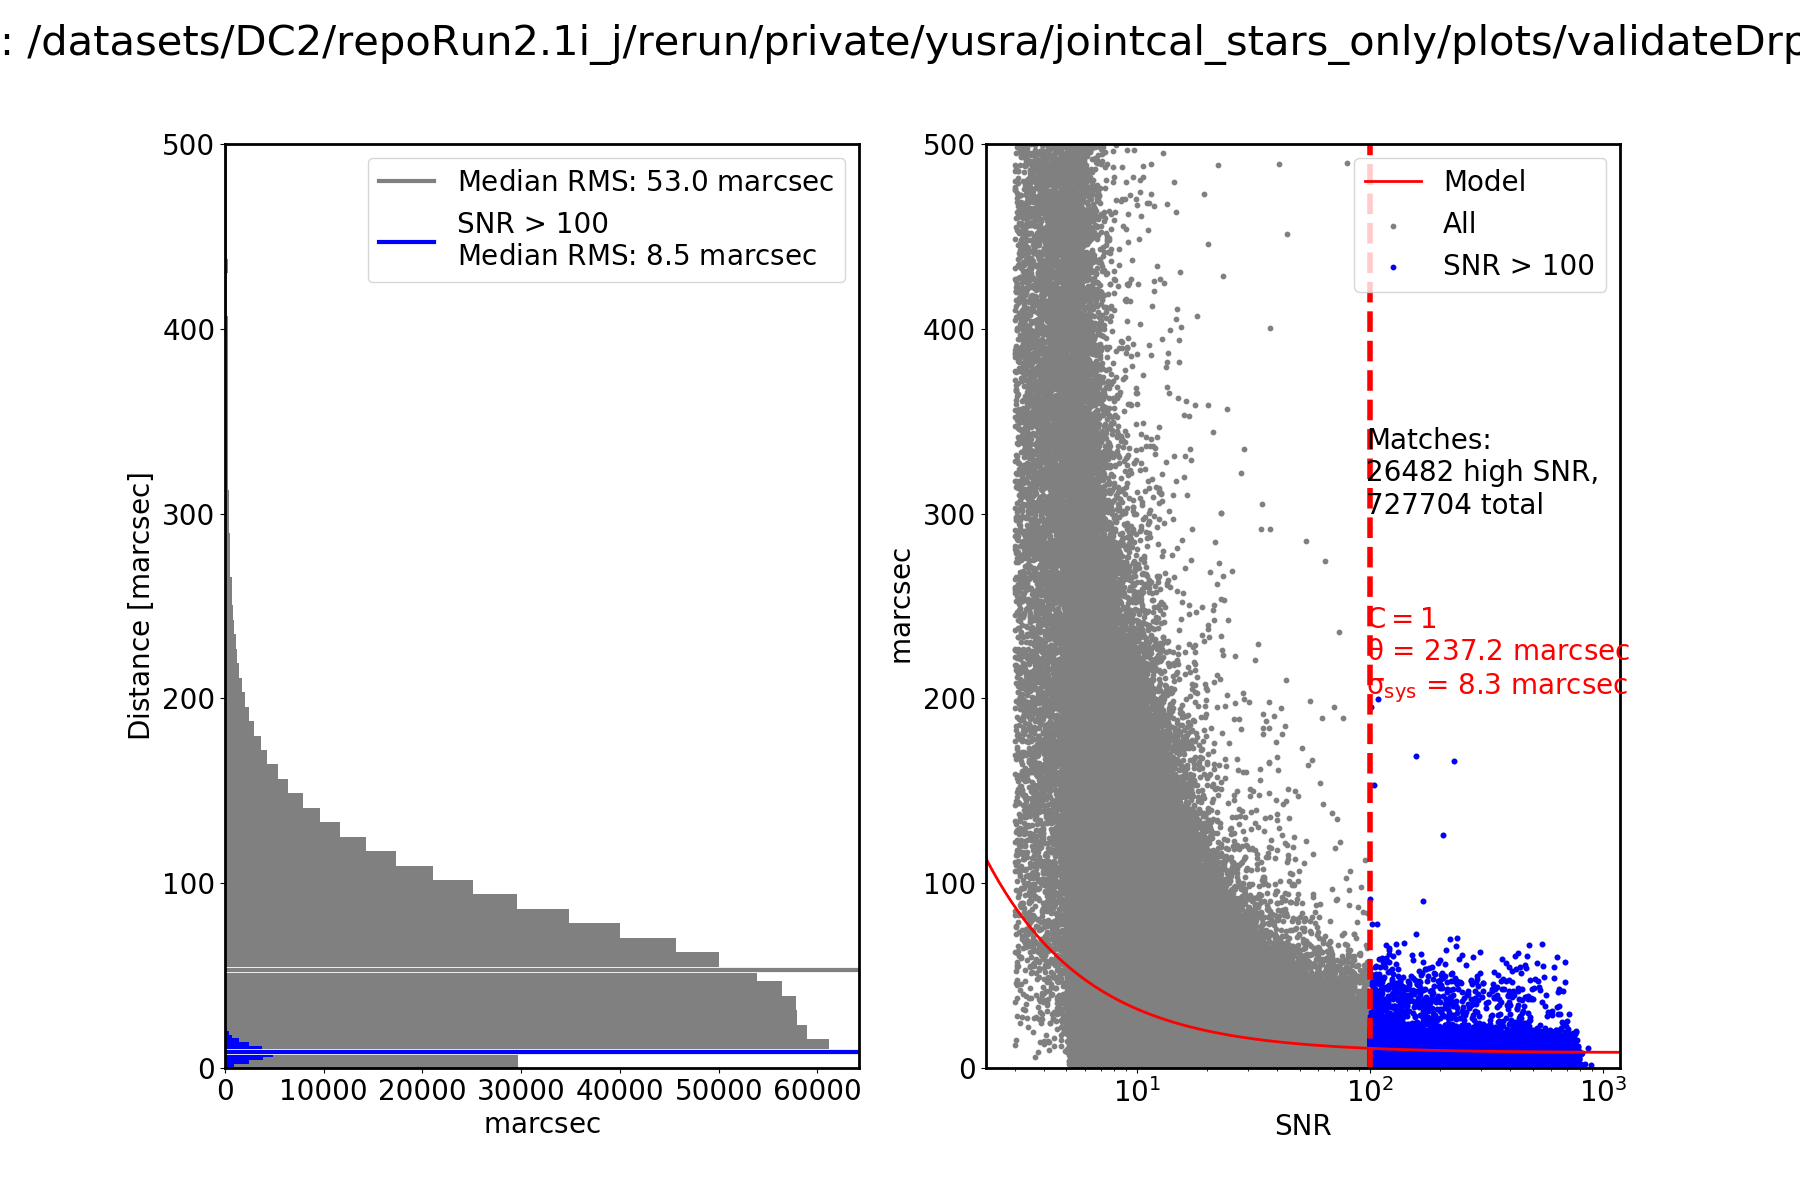

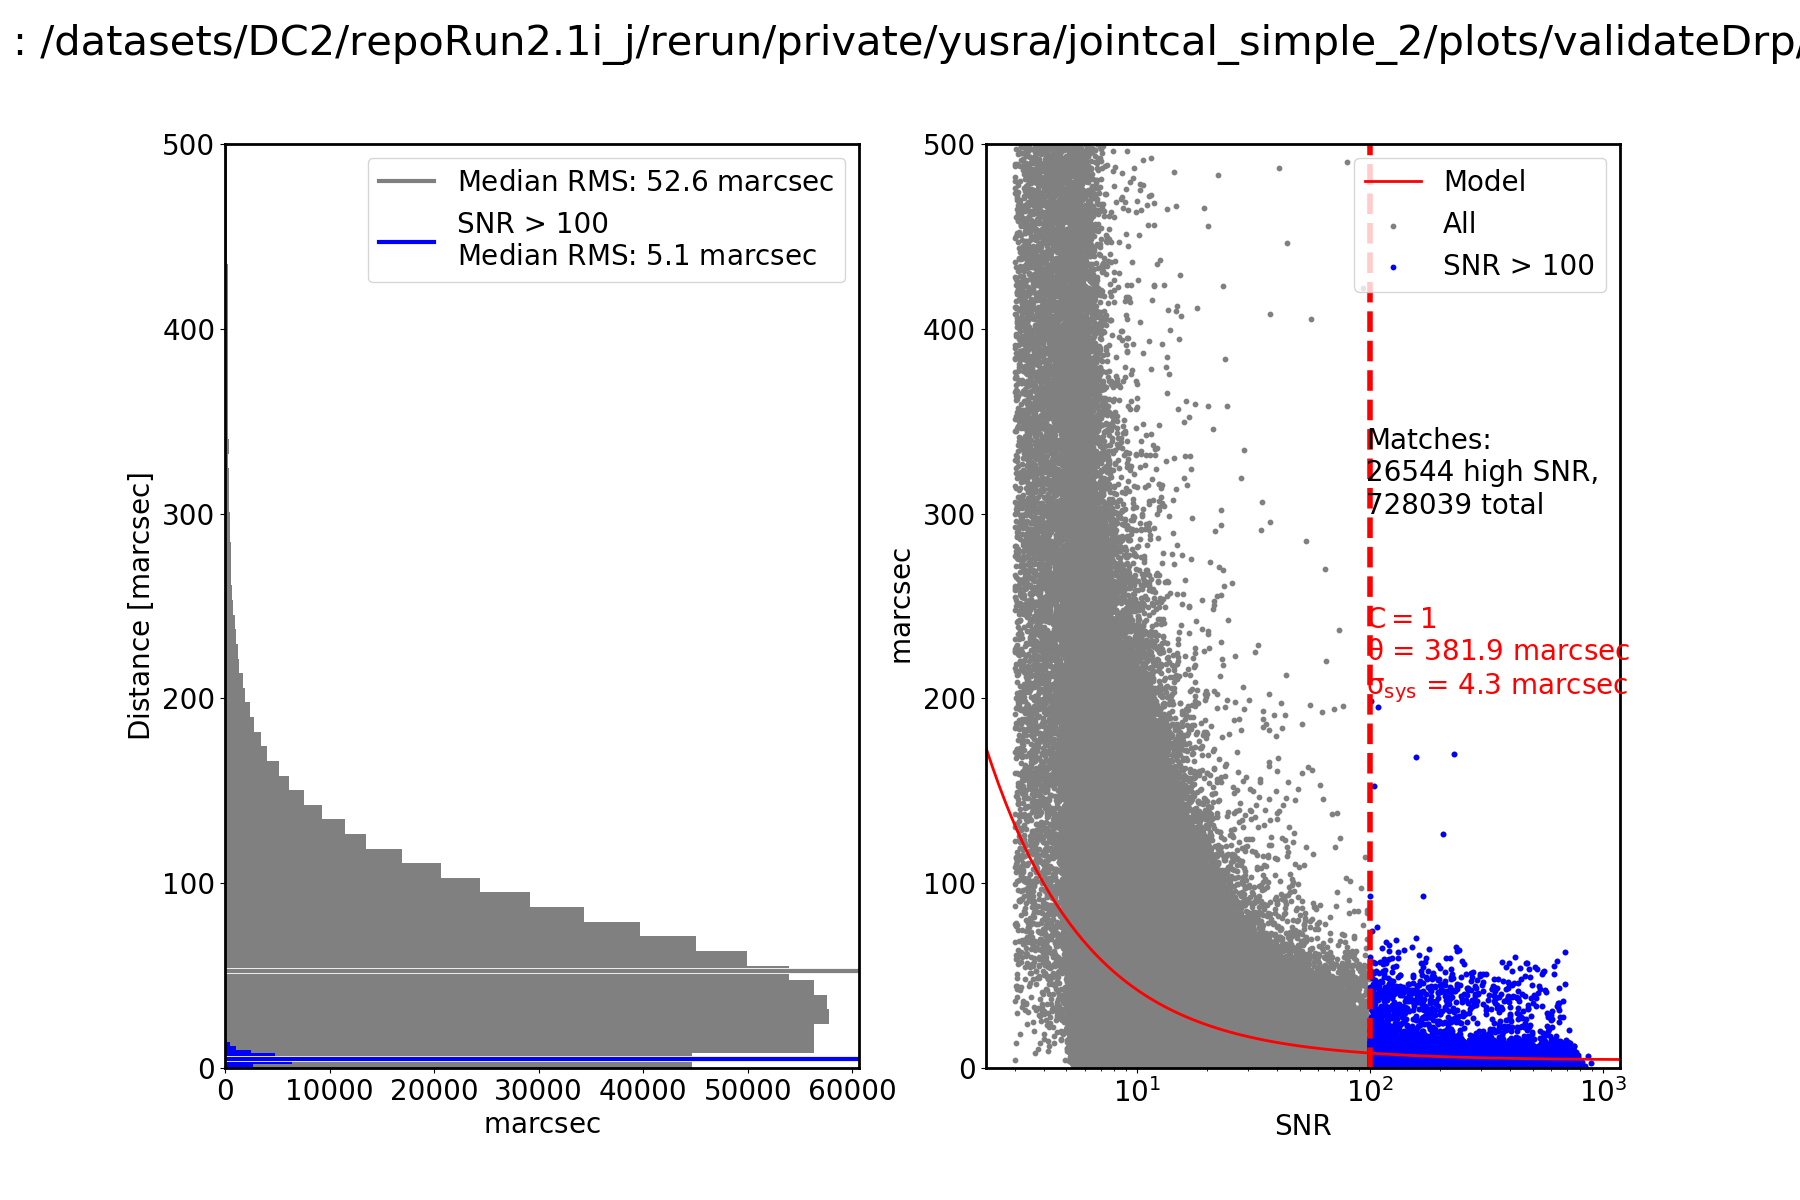

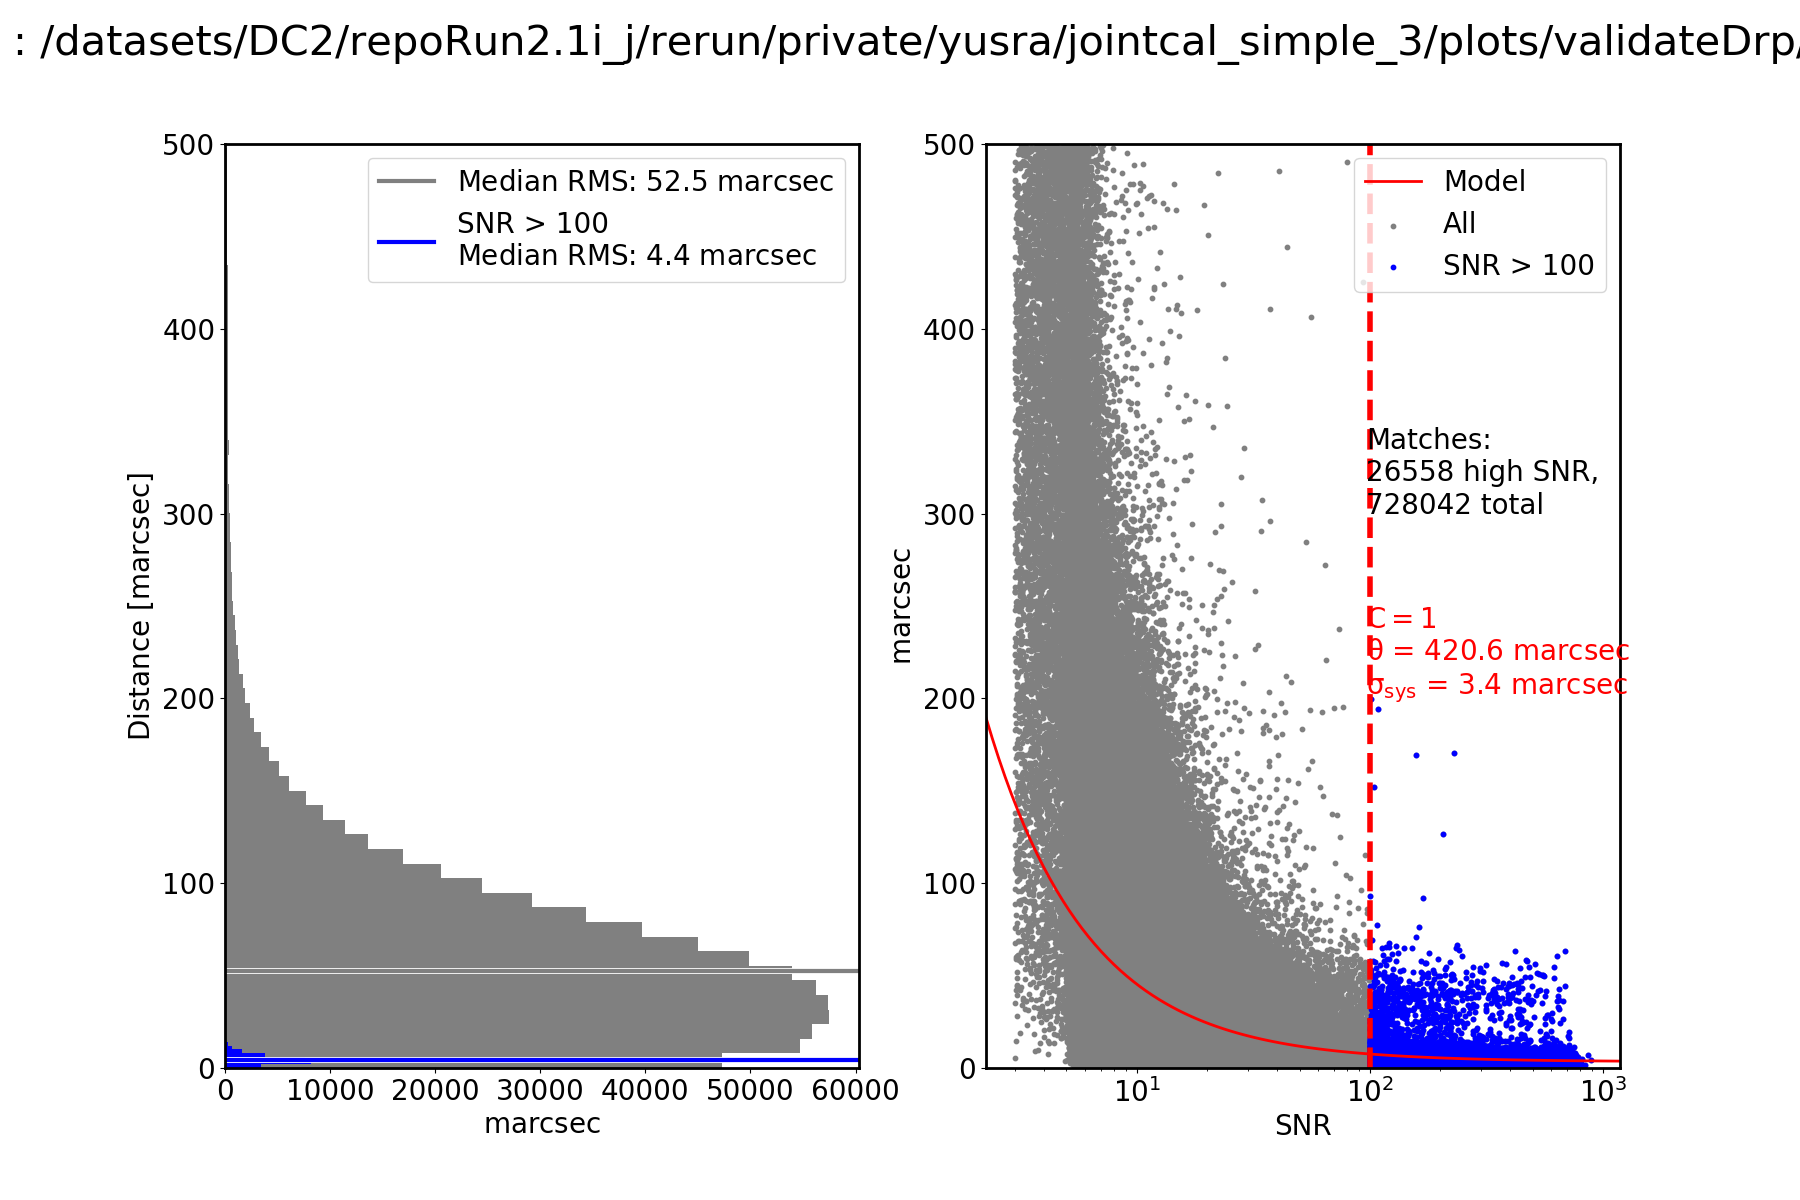

In [26]:
from IPython.display import display
im1 = Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/processCcd/validateDrp/validate-processCcd_i_check_astrometry.png", width=600,)
im2 = Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_default/validateDrp/validate-jointcal_i_check_astrometry.png", width=600,)
im3 = Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_stars_only/validateDrp/validate-jointcal_i_check_astrometry.png", width=600,)
im4 = Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_2/validateDrp/validate-jointcal_i_check_astrometry.png", width=600,)
im5 = Image("https://lsst-web.ncsa.illinois.edu/~yusra/QA_DC2/jointcal_simple_3/validateDrp/validate-jointcal_i_check_astrometry.png", width=600,)
display(im1, im2, im3, im4, im5)

### Comparison of all the validate DRP metrics:

<Figure size 144x432 with 0 Axes>

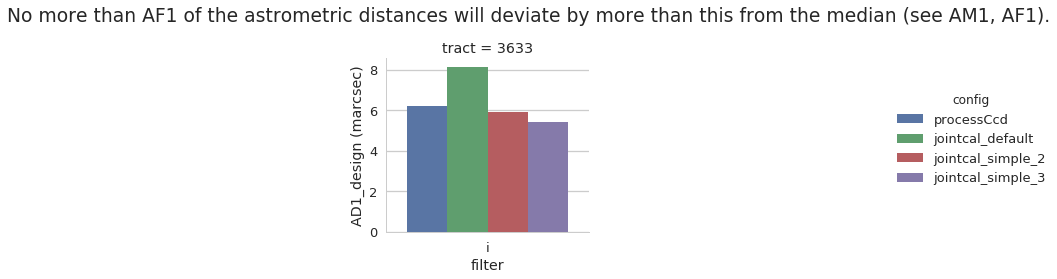

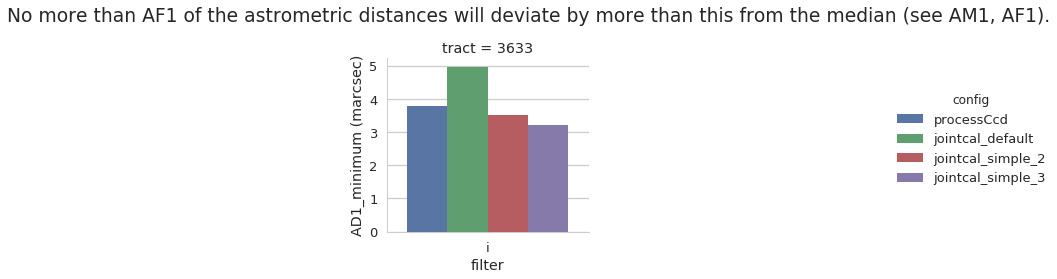

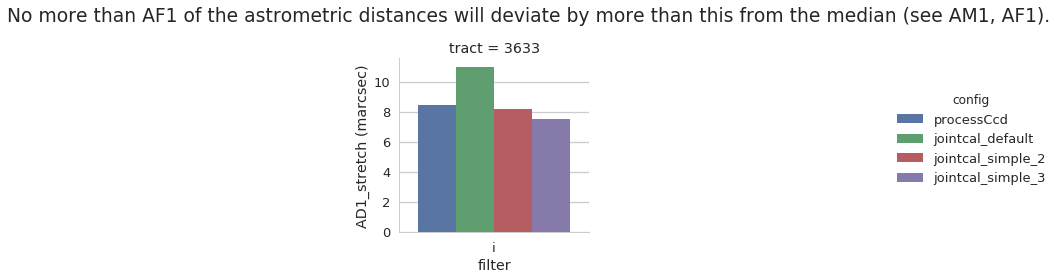

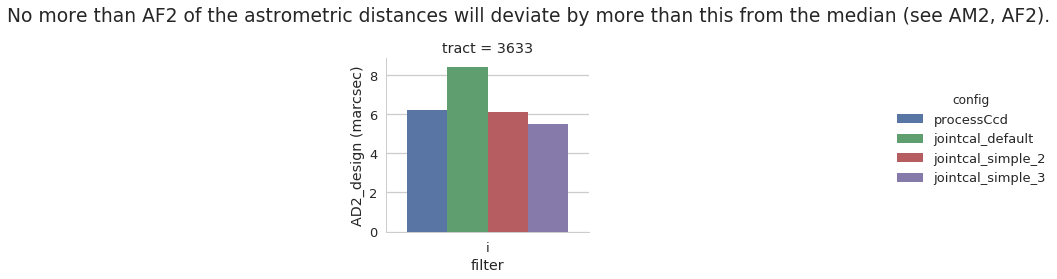

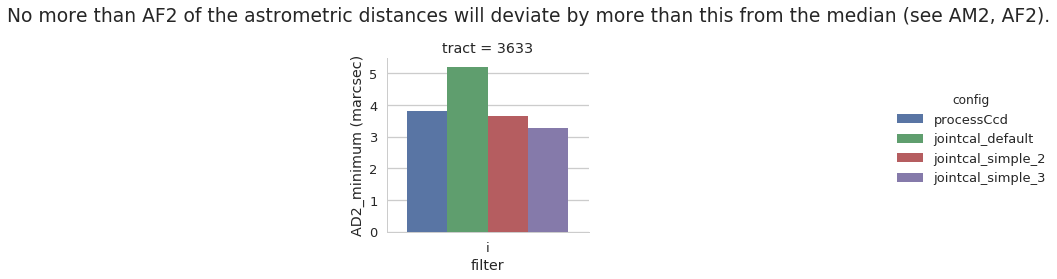

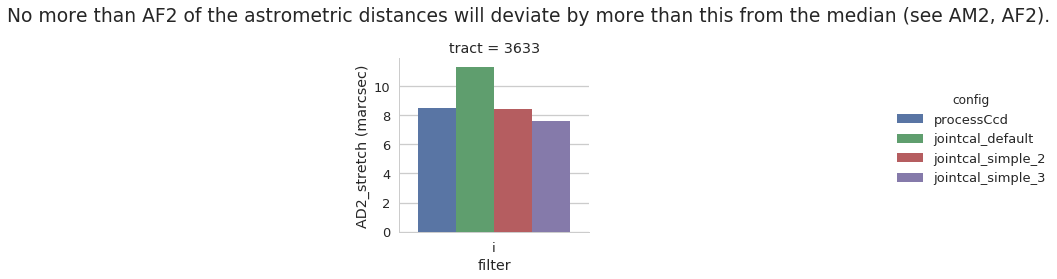

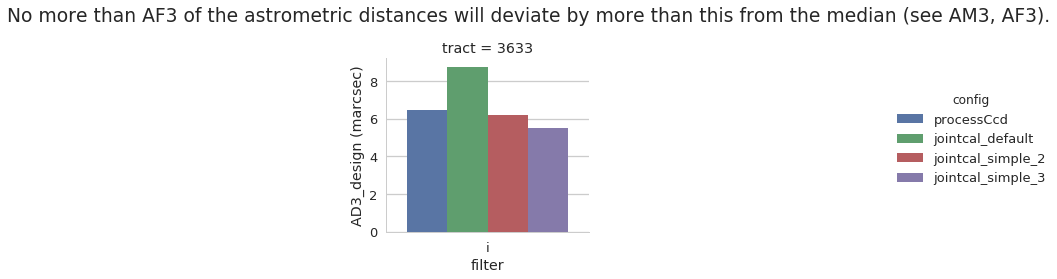

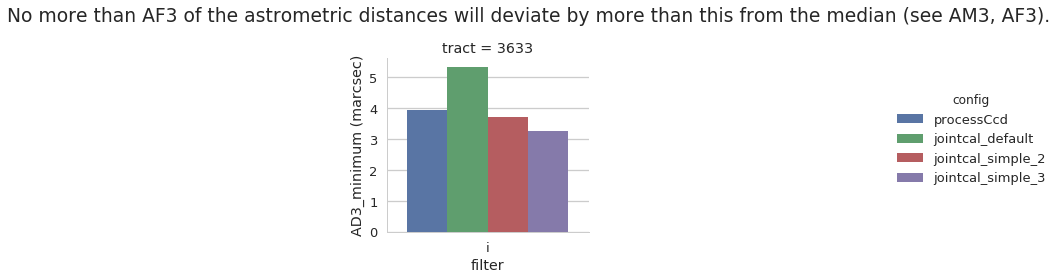

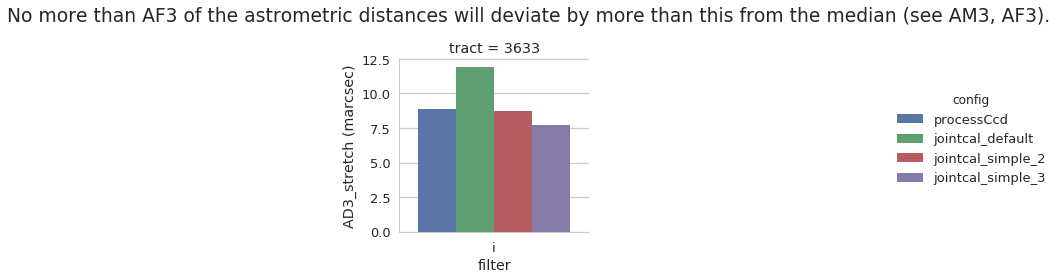

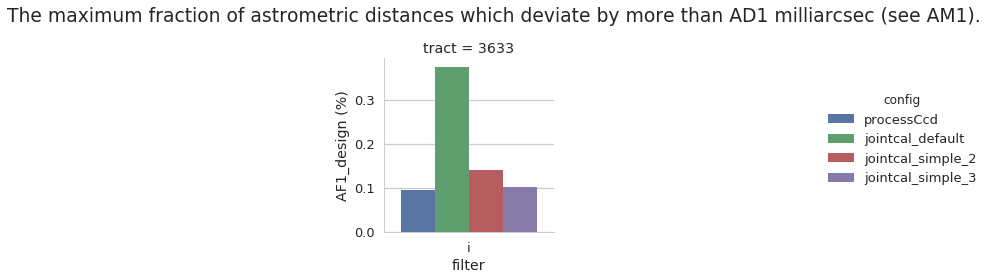

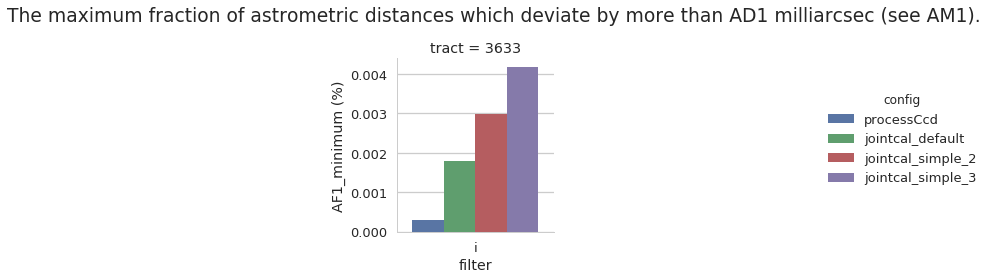

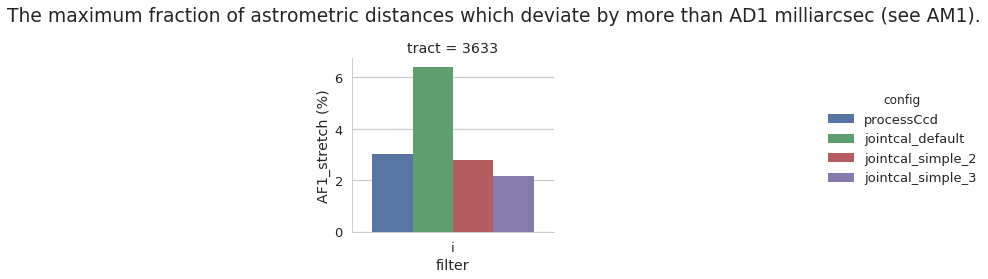

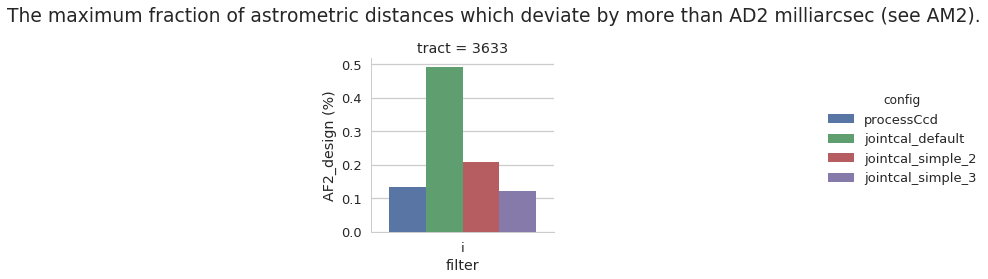

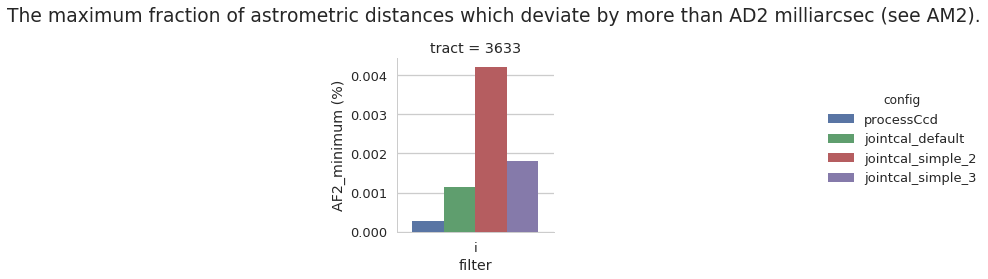

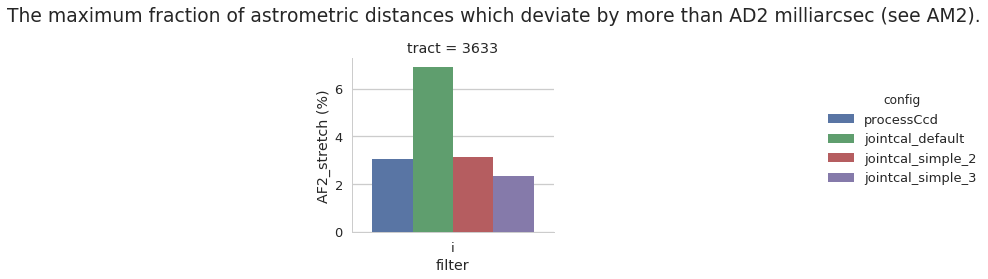

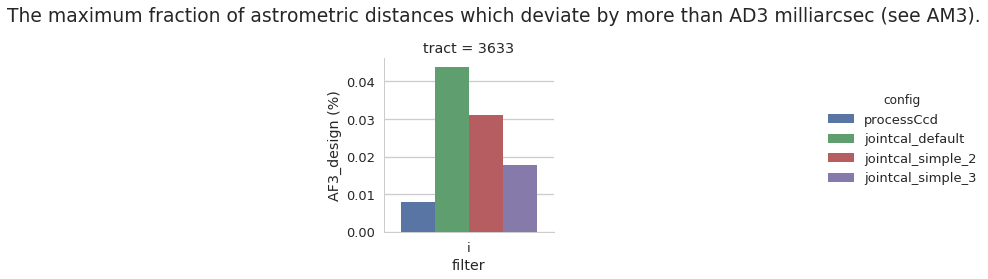

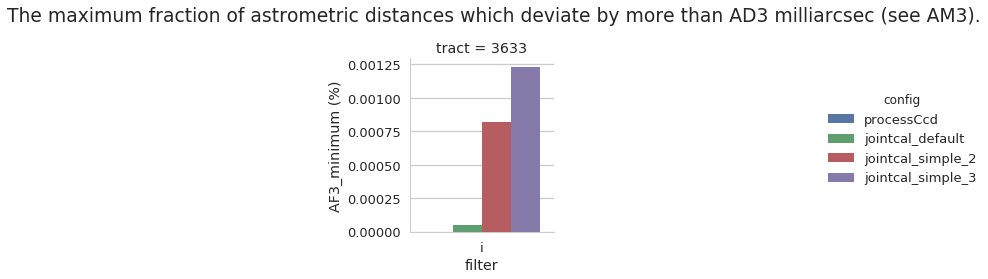

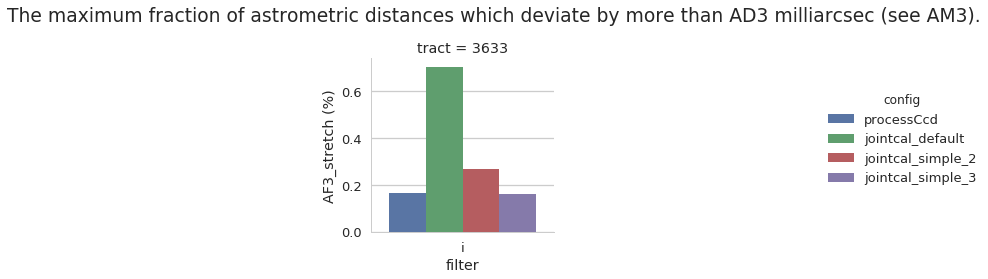

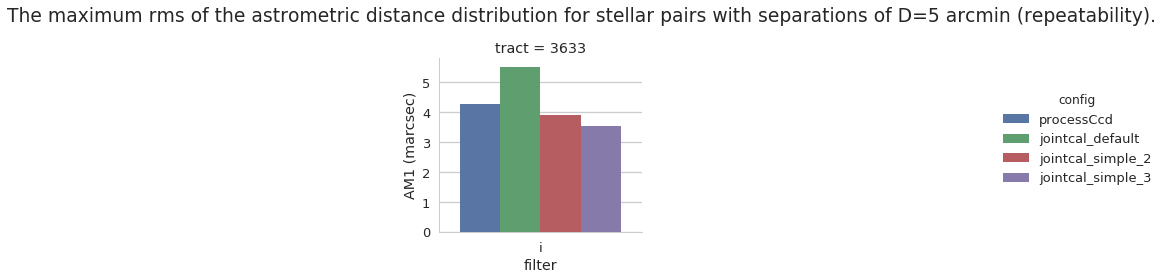

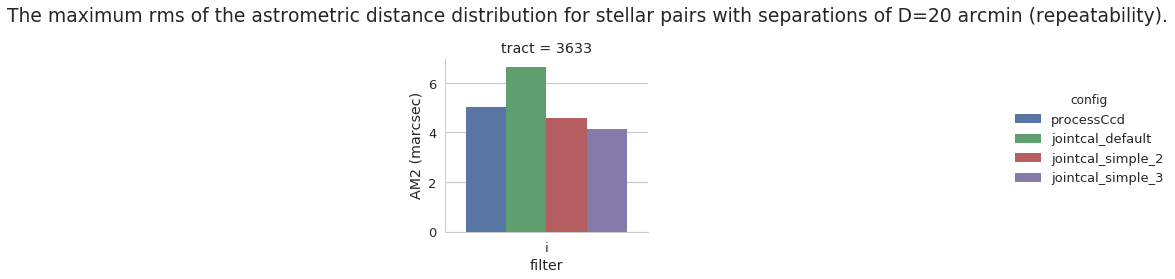

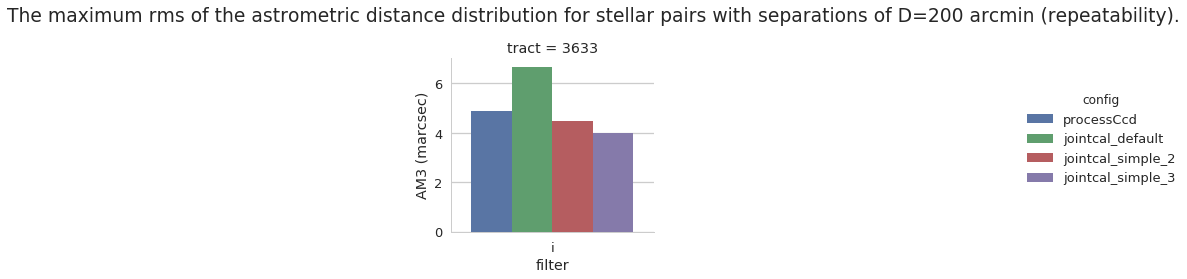

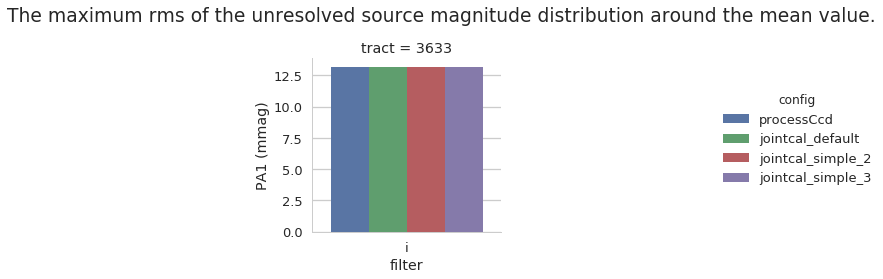

ValueError: Neither the `x` nor `y` variable appears to be numeric.

In [14]:
fig = plt.figure(figsize=(2, 6))
for j, col in enumerate(dc2.columns):
    ax = sns.factorplot(x="filter", y=col, data=dc2[dc2.config != "jointcal_stars_only"],
                        hue="config", col="tract", kind="bar")
    ax.fig.suptitle(unitsDict[col][1])
    ax.fig.subplots_adjust(top=0.8)
    ax.set_ylabels("%s (%s)"%(col, unitsDict[col][0]))
    plt.show()